In [ ]:
##save env file
!conda env export > ods_met_environment.yml

In [1]:
##import all modules here 
import pandas as pd
import matplotlib as plt
import glob
import os
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
from tqdm import tqdm
import codecs
import csv


In [2]:
##set data directories
data_directory_xml = "/mnt/hgfs/shared/weather_warnings/archive_warnings/archive"
data_directory_ods = "/mnt/hgfs/shared/ul_project_Msc_AI/data/met_eireann/eda/Archived_Wx_Warnings_25April2012_17February2021.ods"
full_path_xml = os.path.abspath(data_directory_xml)
full_path_ods = os.path.abspath(data_directory_ods)


if os.path.exists(data_directory_xml):
    print(f"XML format directory exists: {data_directory_xml}")
else:
    print(f"XML format directory does not exist: {data_directory_xml}")
print(os.getcwd())

if os.path.exists(data_directory_ods):
    print(f"ODS format directory exists: {data_directory_ods}")
else:
    print(f"ODS format directory does not exist: {data_directory_ods}")
print(os.getcwd())

XML format directory exists: /mnt/hgfs/shared/weather_warnings/archive_warnings/archive
/mnt/hgfs/shared/ul_project_Msc_AI/data/met_eireann/eda
ODS format directory exists: /mnt/hgfs/shared/ul_project_Msc_AI/data/met_eireann/eda/Archived_Wx_Warnings_25April2012_17February2021.ods
/mnt/hgfs/shared/ul_project_Msc_AI/data/met_eireann/eda


### Import data from old style met_eireann ODS format which was used from 2012 to 2021 

will import data and remove any data from 2012 and any from 2021 (depending on when the data starst/finishes in teh old and new styyle xml format)

In [3]:
### import the ods data into pandas and check some basic values/columns/variables etc
# Read the .ods file
df_ods = pd.read_excel(full_path_ods, engine='odf', parse_dates=['Issue Time', 'Valid From', 'Valid To'])

# check the first few rows
print(df_ods.head())

# look at dataframe info
print(df_ods.info())

# check the df shape
print(f"Number of rows: {df_ods.shape[0]}")
print(f"Number of columns: {df_ods.shape[1]}")

# List column names
print("\nColumn names:")
print(df_ods.columns.tolist())

# look for any missing values
print("\nMissing values:")
print(df_ods.isnull().sum())

# Display summary statistics for numeric columns
print("\nSummary statistics:")
print(df_ods.describe())

           Issue Time          Valid From            Valid To Warning Colour  \
0 2012-04-25 12:00:00 2012-04-25 12:00:00 2012-04-26 12:00:00         Yellow   
1 2012-06-01 21:00:00 2012-06-02 12:00:00 2012-06-03 21:00:00         Yellow   
2 2012-06-02 14:00:00 2012-06-02 14:00:00 2012-06-03 12:00:00         Orange   
3 2012-06-08 10:00:00 2012-06-08 10:00:00 2012-06-08 23:59:00         Yellow   
4 2012-06-14 20:00:00 2012-06-14 20:00:00 2012-06-16 12:00:00         Yellow   

  Warning Element                                        WhereToText  \
0            Rain                               Munster and Leinster   
1            Rain                     Munster, Connacht and Leinster   
2            Rain                               Munster and Leinster   
3            Rain                              Connacht and Leinster   
4            Rain  Munster, Leinster, Connacht, Donegal, Monaghan...   

                                        Warning Text  Munster  Clare   Cork  \
0  Heav

In [4]:
df_ods.head(5)

,Issue Time,Valid From,Valid To,Warning Colour,Warning Element,WhereToText,Warning Text,Munster,Clare,Cork,...,Ulster,Cavan,Donegal,Monaghan,Connacht,Galway,Leitrim,Mayo,Roscommon,Sligo
0,2012-04-25 12:00:00,2012-04-25 12:00:00,2012-04-26 12:00:00,Yellow,Rain,Munster and Leinster,Heavy rain moving into Southern coastal counti...,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,2012-06-01 21:00:00,2012-06-02 12:00:00,2012-06-03 21:00:00,Yellow,Rain,"Munster, Connacht and Leinster","Between 25 and 65 mm of rain possible, (heavie...",True,True,True,...,False,False,False,False,True,True,True,True,True,True
2,2012-06-02 14:00:00,2012-06-02 14:00:00,2012-06-03 12:00:00,Orange,Rain,Munster and Leinster,Between 25mm & 65mm of rain expected over Lein...,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,2012-06-08 10:00:00,2012-06-08 10:00:00,2012-06-08 23:59:00,Yellow,Rain,Connacht and Leinster,Further persistent and sometimes heavy rain to...,False,False,False,...,False,False,False,False,True,True,True,True,True,True
4,2012-06-14 20:00:00,2012-06-14 20:00:00,2012-06-16 12:00:00,Yellow,Rain,"Munster, Leinster, Connacht, Donegal, Monaghan...","Further spells of rain, persistant and heavy a...",True,True,True,...,True,True,True,True,True,True,True,True,True,True


## parse and import XML data

data contains advisories which are notificatiosn of upcoming adverse evets so these can be removed, also some data have no location/wetaher type or severity or descritpion so these will also be removed 

As per ODS , need to check 2021 dates as this is when Met Eireann chaged the format

# County information dictionary
county_info = {
    'EI01': 'Carlow', 'EI02': 'Cavan', 'EI03': 'Clare', 'EI04': 'Cork', 'EI32': 'Cork City',
    'EI06': 'Donegal', 'EI33': 'Dublin City', 'EI34': 'Dún Laoghaire-Rathdown', 'EI35': 'Fingal',
    'EI10': 'Galway', 'EI36': 'Galway City', 'EI11': 'Kerry', 'EI12': 'Kildare', 'EI13': 'Kilkenny',
    'EI15': 'Laois', 'EI14': 'Leitrim', 'EI42': 'Limerick', 'EI37': 'Limerick City', 'EI18': 'Longford',
    'EI19': 'Louth', 'EI20': 'Mayo', 'EI21': 'Meath', 'EI22': 'Monaghan', 'EI23': 'Offaly',
    'EI24': 'Roscommon', 'EI25': 'Sligo', 'EI39': 'South Dublin', 'EI43': 'Tipperary',
    'EI44': 'Waterford', 'EI29': 'Westmeath', 'EI30': 'Wexford', 'EI31': 'Wicklow'
}

def parse_xml(file_path_xml):
    """
    Parse an XML file and extract relevant information.
    
    Args:
    file_path (str): Path to the XML file
    
    Returns:
    dict: Parsed data from the XML file
    None: If there's an error in parsing
    """
    try:
        # Read the file content
        with codecs.open(file_path_xml, 'r', encoding='utf-8', errors='ignore') as file:
            xml_content = file.read()
        
        # Parse the XML content
        root = ET.fromstring(xml_content)
        namespace = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}
        
        # Extract data from the root level
        row = {
            'identifier': get_element_text(root, 'cap:identifier', namespace),
            'sender': get_element_text(root, 'cap:sender', namespace),
            'sent': get_element_text(root, 'cap:sent', namespace),
            'status': get_element_text(root, 'cap:status', namespace),
            'msgType': get_element_text(root, 'cap:msgType', namespace),
            'scope': get_element_text(root, 'cap:scope', namespace),
        }
        
        # Extract data from the info element
        info = root.find('cap:info', namespace)
        if info is not None:
            row.update({
                'language': get_element_text(info, 'cap:language', namespace),
                'category': get_element_text(info, 'cap:category', namespace),
                'event': get_element_text(info, 'cap:event', namespace),
                'responseType': get_element_text(info, 'cap:responseType', namespace),
                'urgency': get_element_text(info, 'cap:urgency', namespace),
                'severity': get_element_text(info, 'cap:severity', namespace),
                'certainty': get_element_text(info, 'cap:certainty', namespace),
                'effective': get_element_text(info, 'cap:effective', namespace),
                'onset': get_element_text(info, 'cap:onset', namespace),
                'expires': get_element_text(info, 'cap:expires', namespace),
                'senderName': get_element_text(info, 'cap:senderName', namespace),
                'headline': get_element_text(info, 'cap:headline', namespace),
                'description': get_element_text(info, 'cap:description', namespace),
                'instruction': get_element_text(info, 'cap:instruction', namespace),
            })
            
            # Extract parameters
            parameters = info.findall('cap:parameter', namespace)
            for param in parameters:
                name = get_element_text(param, 'cap:valueName', namespace)
                value = get_element_text(param, 'cap:value', namespace)
                if name and value:
                    row[f'param_{name}'] = value
            
            # Extract area information
            area = info.find('cap:area', namespace)
            if area is not None:
                row['areaDesc'] = get_element_text(area, 'cap:areaDesc', namespace)
                geocodes = area.findall('cap:geocode', namespace)
                if geocodes:
                    geocode_values = [get_element_text(gc, 'cap:value', namespace) for gc in geocodes if get_element_text(gc, 'cap:valueName', namespace) == 'FIPS']
                    row['counties'] = ';'.join([county_info.get(gc, gc) for gc in geocode_values if gc in county_info])
                else:
                    row['counties'] = 'NaN'
        
        return row
    
    except ET.ParseError as e:
        return None
    except Exception as e:
        return None

def get_element_text(parent, element_name, namespace):
    """
    Extract text from an XML element
    
    Args:
    parent (Element): Parent XML element
    element_name (str): Name of the child element to extract
    namespace (dict): XML namespace
    
    Returns:
    str: Text content of the element, or None if not found
    """
    element = parent.find(element_name, namespace)
    return element.text if element is not None else None

def process_files(data_directory):
    """
    Process all XML files in the given directory and extract weather warning data.
    
    Args:
    data_directory (str): Path to the directory containing XML files
    
    Returns:
    tuple: (DataFrame of parsed data, list of error files)
    """
    file_pattern = os.path.join(data_directory_xml, '*.xml')
    file_list = glob.glob(file_pattern)

    data = []
    error_files = []

    for file in tqdm(file_list, desc="Processing files"):
        row = parse_xml(file)
        if row is not None:
            data.append(row)
        else:
            error_files.append(file)

    # Create DataFrame
    df_xml = pd.DataFrame(data)

    # Convert date fields to datetime
    date_columns = ['sent', 'effective', 'onset', 'expires']
    for col in date_columns:
        if col in df_xml.columns:
            df_xml[col] = pd.to_datetime(df_xml[col], utc=True, errors='coerce')

    # Apply standardization
    df_xml = df_xml.apply(standardize_warning, axis=1)

    return df_xml, error_files

def standardize_warning(row):
    """
    Standardize the warning level and type based on the parsed data.
    
    Args:
    row (dict): A dictionary containing parsed warning data
    
    Returns:
    dict: The input dictionary with added standardized fields
    """
    # Standardize level
    param_awareness_level = str(row.get('param_awareness_level', ''))
    severity = str(row.get('severity', ''))
    
    if 'orange' in param_awareness_level.lower() or 'severe' in severity.lower():
        row['standardized_level'] = 'Orange'
    elif 'red' in param_awareness_level.lower() or 'extreme' in severity.lower():
        row['standardized_level'] = 'Red'
    else:
        row['standardized_level'] = 'Yellow'

    # Standardize severity
    row['standardized_severity'] = severity if severity else 'Unknown'

    # Standardize type - this list is from the met-eireann warning specification
    type_mapping = {
        '1': 'Wind',
        '2': 'Snow-Ice',
        '3': 'Thunderstorm',
        '4': 'Fog',
        '5': 'High-Temperature',
        '6': 'Low-Temperature',
        '10': 'Rain',
        '22': 'Advisory',
        '23': 'Hail'
    }
    
    param_awareness_type = str(row.get('param_awareness_type', ''))
    event = str(row.get('event', ''))
    
    if param_awareness_type:
        try:
            type_code = param_awareness_type.split(';')[0].strip()
            row['standardized_type'] = type_mapping.get(type_code, param_awareness_type)
        except:
            row['standardized_type'] = 'Unknown'
    elif event:
        event_lower = event.lower()
        if 'wind' in event_lower:
            row['standardized_type'] = 'Wind'
        elif 'rain' in event_lower:
            row['standardized_type'] = 'Rain'
        elif 'snow' in event_lower or 'ice' in event_lower:
            row['standardized_type'] = 'Snow-Ice'
        elif 'thunder' in event_lower:
            row['standardized_type'] = 'Thunderstorm'
        elif 'fog' in event_lower:
            row['standardized_type'] = 'Fog'
        elif 'temperature' in event_lower:
            if 'high' in event_lower:
                row['standardized_type'] = 'High-Temperature'
            elif 'low' in event_lower:
                row['standardized_type'] = 'Low-Temperature'
        elif 'hail' in event_lower:
            row['standardized_type'] = 'Hail'
        else:
            row['standardized_type'] = 'Other'
    else:
        row['standardized_type'] = 'Unknown'

    return row

def save_error_files(error_files, output_file):
    """
    Save the list of files that couldn't be parsed to a CSV file.
    
    Args:
    error_files (list): List of file paths that couldn't be parsed
    output_file (str): Path to the output CSV file
    """
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Error Files'])
        for file in error_files:
            writer.writerow([file])

def save_sample_warnings(df_xml, output_file, start_year, end_year, count=50):
    """
    Save a sample of warnings from a specific date range to a CSV file.
    
    Args:
    df (DataFrame): DataFrame containing the warning data
    output_file (str): Path to the output CSV file
    start_year (int): Start year for the sample
    end_year (int): End year for the sample
    count (int): Number of samples to save
    """
    mask = (df_xml['sent'].dt.year >= start_year) & (df_xml['sent'].dt.year <= end_year)
    sample = df_xml[mask].sample(min(count, sum(mask)))
    sample.to_csv(output_file, index=False)

# Main script
df_xml, error_files = process_files(data_directory_xml)

# Save the full DataFrame to CSV
df_xml.to_csv('xml_all_weather_warnings.csv', index=False)

# Save error files
save_error_files(error_files, 'xml_error_files.csv')

# Save sample warnings
save_sample_warnings(df_xml, 'xml_pre_2021_warnings.csv', 2017, 2020)
save_sample_warnings(df_xml, 'xml_post_2020_warnings.csv', 2021, df_xml['sent'].dt.year.max())

print("Processing Summary:")
print(f"Total files processed: {len(df_xml) + len(error_files)}")
print(f"Files successfully parsed: {len(df_xml)}")
print(f"Files with errors: {len(error_files)}")

if 'sent' in df_xml.columns:
    print(f"Data covers the period from {df_xml['sent'].min().strftime('%d/%m/%Y')} to {df_xml['sent'].max().strftime('%d/%m/%Y')}")
else:
    print("No valid dates found in the data")

print("\nFull dataset saved to 'all_weather_warnings.csv'")
print("Error files saved to 'error_files.csv'")
print("Sample of pre-2021 warnings saved to 'pre_2021_warnings.csv'")
print("Sample of post-2020 warnings saved to 'post_2020_warnings.csv'")

missing_type_with_level = df_xml[
    (df_xml['param_awareness_type'].isna()) & 
    (df_xml['param_awareness_level'].notna())
]

# Display basic info about these rows
print("Number of rows with missing awareness_type but having awareness_level:", 
      len(missing_type_with_level))

# Show the unique values in awareness_level for these rows
print("\nUnique awareness levels in these rows:")
print(missing_type_with_level['param_awareness_level'].value_counts())

# Count Moderate Advisory occurrences
moderate_advisory_count = missing_type_with_level[
    missing_type_with_level['headline'].str.contains('Moderate Advisory', na=False)
]

# Count Moderate Advisory occurrences
moderate_warning_count = missing_type_with_level[
    missing_type_with_level['headline'].str.contains('warning for', na=False)
]

print("\nAnalysis of Moderate Advisory:")
print(f"Number of Moderate Advisory entries: {len(moderate_advisory_count)}")

print("\nAnalysis of Warning Advisory:")
print(f"Number of Moderate Advisory entries: {len(moderate_warning_count)}")

# Find rows with missing awareness_type but having awareness_level and create a proper copy
missing_type_with_level = df_xml[
    (df_xml['param_awareness_type'].isna()) & 
    (df_xml['param_awareness_level'].notna())
].copy()  

# Define weather patterns to look for
weather_patterns = ['rain', 'hail', 'snow', 'wind', 'thunder', 'storm', 'fog', 'ice', 'frost']

# Function to check if any weather pattern exists in the headline
def find_weather_pattern(headline):
    if isinstance(headline, str):  
        headline = headline.lower()  
        found_patterns = [pattern for pattern in weather_patterns if pattern in headline]
        return ', '.join(found_patterns) if found_patterns else 'No weather pattern found'
    return 'No headline'

# Function to categorize headlines
def categorize_headline_detailed(headline):
    if not isinstance(headline, str):
        return 'No headline'
    
    headline_lower = headline.lower()
    
    # List of specific weather terms
    weather_terms = ['rain', 'snow', 'wind', 'storm', 'fog', 'ice', 'frost', 
                    'thunder', 'lightning', 'temperature', 'flood', 'heat', 
                    'cold', 'gale', 'visibility']
    
    if headline_lower.strip() == 'warning for':
        return 'Invalid Event (Warning for only)'
    elif 'warning for' in headline_lower and not any(term in headline_lower for term in weather_terms):
        return 'Potentially Invalid (Warning for without weather terms)'
    elif 'warning for' in headline_lower:
        return 'Valid Warning with Weather Details'
    else:
        return 'Other'

# Add columns for weather patterns and categories
missing_type_with_level.loc[:, 'weather_pattern'] = missing_type_with_level['headline'].apply(find_weather_pattern)
missing_type_with_level.loc[:, 'headline_category'] = missing_type_with_level['headline'].apply(categorize_headline_detailed)

# Display analysis
print("Analysis of weather patterns in headlines:")
print("Total rows analyzed:", len(missing_type_with_level))

# Show distribution of weather patterns
print("\nDistribution of weather patterns found:")
print(missing_type_with_level['weather_pattern'].value_counts())

# Show distribution of awareness levels for each weather pattern
print("\nAwareness levels by weather pattern:")
weather_level_dist = pd.crosstab(
    missing_type_with_level['weather_pattern'],
    missing_type_with_level['param_awareness_level']
)
print(weather_level_dist)

# Show some example rows for each weather pattern
print("\nExample headlines for each weather pattern:")
for pattern in weather_patterns:
    pattern_rows = missing_type_with_level[
        missing_type_with_level['headline'].str.lower().str.contains(pattern, na=False)
    ]
    if len(pattern_rows) > 0:
        print(f"\n{pattern.upper()} examples:")
        print(pattern_rows[['headline', 'param_awareness_level']].head(3))

# Time distribution
print("\nTime distribution of different weather patterns:")
missing_type_with_level.loc[:, 'year'] = missing_type_with_level['sent'].dt.year
yearly_patterns = pd.crosstab(
    missing_type_with_level['year'],
    missing_type_with_level['weather_pattern']
)
print(yearly_patterns)

# Seasonal analysis
missing_type_with_level.loc[:, 'season'] = missing_type_with_level['sent'].dt.month.map({
    12:'Winter', 1:'Winter', 2:'Winter',
    3:'Spring', 4:'Spring', 5:'Spring',
    6:'Summer', 7:'Summer', 8:'Summer',
    9:'Autumn', 10:'Autumn', 11:'Autumn'
})

print("\nSeasonal distribution of weather patterns:")
seasonal_patterns = pd.crosstab(
    missing_type_with_level['season'],
    missing_type_with_level['weather_pattern']
)
print(seasonal_patterns)

# Common combinations of weather patterns
print("\nCommon combinations of weather patterns:")
print(missing_type_with_level['headline'].str.lower().apply(
    lambda x: ', '.join(sorted([p for p in weather_patterns if p in str(x)]))
).value_counts().head(10))

# Headline Categories Analysis
print("\nHeadline Categories Analysis:")
print(missing_type_with_level['headline_category'].value_counts())

# Show examples of each category
print("\nExamples of different headline categories:")
for category in missing_type_with_level['headline_category'].unique():
    print(f"\n{category} examples:")
    examples = missing_type_with_level[
        missing_type_with_level['headline_category'] == category
    ][['sent', 'headline', 'param_awareness_level']].head(3)
    print(examples)

# Count invalid events by awareness level
print("\nAwareness levels for Invalid Events (Warning for only):")
invalid_events = missing_type_with_level[
    missing_type_with_level['headline_category'] == 'Invalid Event (Warning for only)'
]
print(invalid_events['param_awareness_level'].value_counts())

# Distribution over time for invalid events
print("\nYearly distribution of Invalid Events:")
print(invalid_events['year'].value_counts().sort_index())

# Create filtered dataset without invalid events
valid_events = missing_type_with_level[
    missing_type_with_level['headline_category'] != 'Invalid Event (Warning for only)'
].copy()

print("\nAnalysis after removing invalid events:")
print(f"Original number of events: {len(missing_type_with_level)}")
print(f"Number of valid events: {len(valid_events)}")
print(f"Number of invalid events removed: {len(missing_type_with_level) - len(valid_events)}")

# Show distribution of weather patterns in valid events
print("\nWeather patterns in valid events:")
print(valid_events['weather_pattern'].value_counts())

# Optional: Save the analysis to CSV
# valid_events.to_csv('xml_valid_events_analysis.csv', index=False)
# invalid_events.to_csv('xml_invalid_events_analysis.csv', index=False)

# Analyze counties data in "Warning for" events
print("\nAnalysis of counties data in 'Warning for' events:")

# Check for missing counties
counties_check = {
    'Total rows': len(warning_for_only),
    'Missing counties': warning_for_only['counties'].isna().sum(),
    'Empty string counties': len(warning_for_only[warning_for_only['counties'] == '']),
    'Has counties data': len(warning_for_only[warning_for_only['counties'].notna() & (warning_for_only['counties'] != '')])
}

print("\nCounties data summary:")
for key, value in counties_check.items():
    print(f"{key}: {value}")

# Show distribution of counties where they exist
print("\nDistribution of counties (where data exists):")
valid_counties = warning_for_only[
    warning_for_only['counties'].notna() & 
    (warning_for_only['counties'] != '')
]

if len(valid_counties) > 0:
    print("\nSample of events with counties data:")
    print(valid_counties[['sent', 'headline', 'counties', 'param_awareness_level']].head())
else:
    print("No events found with valid counties data")

# Update the CSV export to highlight counties information
warning_for_only['counties_status'] = warning_for_only['counties'].apply(
    lambda x: 'Has Data' if isinstance(x, str) and x != '' else 'No Data'
)

# Export updated data
columns_to_export = [
    'sent', 
    'headline', 
    'param_awareness_level',
    'param_awareness_type',
    'standardized_type',
    'counties',
    'counties_status',
    'weather_pattern',
    'headline_category'
]

# Export to CSV with counties status included
print("\nExporting updated data with counties status...")
warning_for_only[columns_to_export].to_csv('warning_for_only_events_with_counties.csv', index=False)

# Show distribution by counties status and year
print("\nYearly distribution of events by counties status:")
yearly_counties_dist = pd.crosstab(
    warning_for_only['year'],
    warning_for_only['counties_status']
)
print(yearly_counties_dist)

In [ ]:
print(f"Number of rows with missing counties data: {df_xml['counties'].isna().sum()} out of {len(df_xml)} total rows")

In [ ]:
##drop any advisory type events 
df_xml = df_xml[~df_xml['standardized_type'].str.lower().str.contains('advisory')]

In [ ]:
#export all rows that have "warning for" in headline for review 
warning_for_only = missing_type_with_level[
    missing_type_with_level['headline_category'] == 'Invalid Event (Warning for only)'
].copy()

# Select relevant columns for review
columns_to_export = [
    'sent',
    'identifier',
    'headline', 
    'param_awareness_level',
    'param_awareness_type',
    'standardized_type',
    'weather_pattern',
    'headline_category'
]

# Export to CSV
print(f"\nExporting {len(warning_for_only)} 'Warning for' only rows to CSV")
warning_for_only[columns_to_export].to_csv('warning_for_only_events.csv', index=False)

### based on the above
any advisory events can be excluded
any event that has no awarenes_type or gecode can also be excluded as these appear to be false events 

# County information dictionary
county_info = {
    'EI01': 'Carlow', 'EI02': 'Cavan', 'EI03': 'Clare', 'EI04': 'Cork', 'EI32': 'Cork City',
    'EI06': 'Donegal', 'EI33': 'Dublin City', 'EI34': 'Dún Laoghaire-Rathdown', 'EI35': 'Fingal',
    'EI10': 'Galway', 'EI36': 'Galway City', 'EI11': 'Kerry', 'EI12': 'Kildare', 'EI13': 'Kilkenny',
    'EI15': 'Laois', 'EI14': 'Leitrim', 'EI42': 'Limerick', 'EI37': 'Limerick City', 'EI18': 'Longford',
    'EI19': 'Louth', 'EI20': 'Mayo', 'EI21': 'Meath', 'EI22': 'Monaghan', 'EI23': 'Offaly',
    'EI24': 'Roscommon', 'EI25': 'Sligo', 'EI39': 'South Dublin', 'EI43': 'Tipperary',
    'EI44': 'Waterford', 'EI29': 'Westmeath', 'EI30': 'Wexford', 'EI31': 'Wicklow'
}

def parse_xml(file_path_xml):
    """
    Parse an XML file and extract relevant information.
    
    Args:
    file_path (str): Path to the XML file
    
    Returns:
    dict: Parsed data from the XML file
    None: If there's an error in parsing or if the warning doesn't meet inclusion criteria
    """
    try:
        # Read the file content
        with codecs.open(file_path_xml, 'r', encoding='utf-8', errors='ignore') as file:
            xml_content = file.read()
        
        # Parse the XML content
        root = ET.fromstring(xml_content)
        namespace = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}
        
        # Extract data from the info element first to check if we should process this warning
        info = root.find('cap:info', namespace)
        if info is None:
            return None
            
        # Get awareness type parameter early
        has_awareness_type = False
        parameters = info.findall('cap:parameter', namespace)
        for param in parameters:
            if get_element_text(param, 'cap:valueName', namespace) == 'awareness_type':
                has_awareness_type = True
                awareness_type = get_element_text(param, 'cap:value', namespace)
                # Check if it's an advisory (type 22)
                if awareness_type and '22' in awareness_type:
                    return None
                break
        
        if not has_awareness_type:
            return None
            
        # Check for county information early
        area = info.find('cap:area', namespace)
        if area is None:
            return None
            
        geocodes = area.findall('cap:geocode', namespace)
        if not geocodes:
            return None
            
        # Check if there are valid county codes
        valid_counties = False
        for gc in geocodes:
            if (get_element_text(gc, 'cap:valueName', namespace) == 'FIPS' and 
                get_element_text(gc, 'cap:value', namespace) in county_info):
                valid_counties = True
                break
        
        if not valid_counties:
            return None
        
        # If we've made it here, the warning meets our criteria
        # Extract root level data
        row = {
            'identifier': get_element_text(root, 'cap:identifier', namespace),
            'sender': get_element_text(root, 'cap:sender', namespace),
            'sent': get_element_text(root, 'cap:sent', namespace),
            'status': get_element_text(root, 'cap:status', namespace),
            'msgType': get_element_text(root, 'cap:msgType', namespace),
            'scope': get_element_text(root, 'cap:scope', namespace),
        }
        
        # Extract info element data
        row.update({
            'language': get_element_text(info, 'cap:language', namespace),
            'category': get_element_text(info, 'cap:category', namespace),
            'event': get_element_text(info, 'cap:event', namespace),
            'responseType': get_element_text(info, 'cap:responseType', namespace),
            'urgency': get_element_text(info, 'cap:urgency', namespace),
            'severity': get_element_text(info, 'cap:severity', namespace),
            'certainty': get_element_text(info, 'cap:certainty', namespace),
            'effective': get_element_text(info, 'cap:effective', namespace),
            'onset': get_element_text(info, 'cap:onset', namespace),
            'expires': get_element_text(info, 'cap:expires', namespace),
            'senderName': get_element_text(info, 'cap:senderName', namespace),
            'headline': get_element_text(info, 'cap:headline', namespace),
            'description': get_element_text(info, 'cap:description', namespace),
            'instruction': get_element_text(info, 'cap:instruction', namespace),
        })
        
        # Extract parameters
        for param in parameters:
            name = get_element_text(param, 'cap:valueName', namespace)
            value = get_element_text(param, 'cap:value', namespace)
            if name and value:
                row[f'param_{name}'] = value
        
        # Extract area information
        row['areaDesc'] = get_element_text(area, 'cap:areaDesc', namespace)
        geocode_values = [get_element_text(gc, 'cap:value', namespace) 
                         for gc in geocodes 
                         if get_element_text(gc, 'cap:valueName', namespace) == 'FIPS']
        row['counties'] = ';'.join([county_info[gc] 
                                  for gc in geocode_values 
                                  if gc in county_info])
        
        return row
    
    except ET.ParseError as e:
        return None
    except Exception as e:
        return None

def process_files(data_directory):
    """
    Process all XML files in the given directory and extract weather warning data.
    
    Args:
    data_directory (str): Path to the directory containing XML files
    
    Returns:
    tuple: (DataFrame of parsed data, list of error files, list of excluded files)
    """
    file_pattern = os.path.join(data_directory, '*.xml')
    file_list = glob.glob(file_pattern)

    data = []
    error_files = []
    excluded_files = []  # New list to track files that don't meet criteria

    for file in tqdm(file_list, desc="Processing files"):
        row = parse_xml(file)
        if row is not None:
            data.append(row)
        else:
            try:
                with codecs.open(file, 'r', encoding='utf-8', errors='ignore') as f:
                    ET.parse(f)
                excluded_files.append(file)  # File parsed but didn't meet criteria
            except:
                error_files.append(file)  # File couldn't be parsed

    # Create DataFrame
    df_xml = pd.DataFrame(data)

    # Convert date fields to datetime
    date_columns = ['sent', 'effective', 'onset', 'expires']
    for col in date_columns:
        if col in df_xml.columns:
            df_xml[col] = pd.to_datetime(df_xml[col], utc=True, errors='coerce')

    # Apply standardization
    df_xml = df_xml.apply(standardize_warning, axis=1)

    return df_xml, error_files, excluded_files

# Update the main script to handle excluded files
df_xml, error_files, excluded_files = process_files(data_directory_xml)

# Save the full DataFrame to CSV
df_xml.to_csv('xml_all_weather_warnings.csv', index=False)

# Save error and excluded files
save_error_files(error_files, 'xml_error_files.csv')
save_error_files(excluded_files, 'xml_excluded_files.csv')

print("Processing Summary:")
print(f"Total files processed: {len(df_xml) + len(error_files) + len(excluded_files)}")
print(f"Files successfully parsed and included: {len(df_xml)}")
print(f"Files excluded (didn't meet criteria): {len(excluded_files)}")
print(f"Files with parsing errors: {len(error_files)}")

if 'sent' in df_xml.columns:
    print(f"Data covers the period from {df_xml['sent'].min().strftime('%d/%m/%Y')} to {df_xml['sent'].max().strftime('%d/%m/%Y')}")
else:
    print("No valid dates found in the data")

print("\nFull dataset saved to 'all_weather_warnings.csv'")
print("Error files saved to 'error_files.csv'")
print("Excluded files saved to 'excluded_files.csv'")

(df_xml.isna().sum()/df_xml.shape[0] * 100).sort_values()

# Show rows where param_awareness_type is missing
missing_rows = df_xml[df_xml['param_awareness_type'].isna()]

# Display the results
print("Number of rows with missing param_awareness_type:", len(missing_rows))
print("\nSample of rows with missing values:")
print(missing_rows[['sent', 'identifier','standardized_type', 'param_awareness_type', 'headline']].head(50))

### Start and end dates for data frames

# New Approach
    this is a new function to parse xml but output to same format as ods so i can combine them 

In [5]:
# County code to county name mapping
county_info = {
    'EI01': 'Carlow', 'EI02': 'Cavan', 'EI03': 'Clare', 'EI04': 'Cork', 'EI32': 'Cork',
    'EI06': 'Donegal', 'EI33': 'Dublin', 'EI34': 'Dublin', 'EI35': 'Dublin',
    'EI10': 'Galway', 'EI36': 'Galway', 'EI11': 'Kerry', 'EI12': 'Kildare', 'EI13': 'Kilkenny',
    'EI15': 'Laois', 'EI14': 'Leitrim', 'EI42': 'Limerick', 'EI37': 'Limerick', 'EI18': 'Longford',
    'EI19': 'Louth', 'EI20': 'Mayo', 'EI21': 'Meath', 'EI22': 'Monaghan', 'EI23': 'Offaly',
    'EI24': 'Roscommon', 'EI25': 'Sligo', 'EI39': 'Dublin', 'EI43': 'Tipperary',
    'EI44': 'Waterford', 'EI29': 'Westmeath', 'EI30': 'Wexford', 'EI31': 'Wicklow',
    # Add 'Tipperary SR' mapping if needed
}

# Define counties in each region
county_to_region = {
    'Munster': ['Clare', 'Cork', 'Kerry', 'Limerick', 'Tipperary', 'Waterford'],
    'Leinster': ['Carlow', 'Dublin', 'Kildare', 'Kilkenny', 'Laois', 'Longford', 'Louth', 'Meath', 'Offaly', 'Westmeath', 'Wexford', 'Wicklow'],
    'Ulster': ['Cavan', 'Donegal', 'Monaghan'],
    'Connacht': ['Galway', 'Leitrim', 'Mayo', 'Roscommon', 'Sligo']
}

# Define the output columns in the desired order
output_columns = [
    'Issue Time', 'Valid From', 'Valid To', 'Warning Colour', 'Warning Element',
    'WhereToText', 'Warning Text', 'Munster', 'Clare', 'Cork', 'Kerry', 'Limerick', 'Tipperary', 'Tipperary SR',
    'Waterford', 'Leinster', 'Carlow', 'Dublin', 'Kildare', 'Kilkenny', 'Laois',
    'Longford', 'Louth', 'Meath', 'Offaly', 'Westmeath', 'Wexford', 'Wicklow',
    'Ulster', 'Cavan', 'Donegal', 'Monaghan', 'Connacht', 'Galway', 'Leitrim', 'Mayo', 'Roscommon', 'Sligo'
]


In [6]:
import xml.etree.ElementTree as ET
import pandas as pd
import glob
import os
from tqdm import tqdm

def parse_xml_to_row(file_path, county_info, county_to_region):
    """
    Parse an XML file and extract relevant information into a dictionary.
    """
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        namespace = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}

        # Initialize the row dictionary with default values
        row = {col: None for col in output_columns}
        for county in county_info.values():
            row[county] = False  # Initialize county flags to False

        # Extract fields from the XML
        row['Issue Time'] = root.find('cap:sent', namespace).text
        info = root.find('cap:info', namespace)
        if info is None:
            return None  # Skip if no info section

        row['Valid From'] = (info.find('cap:effective', namespace) or info.find('cap:onset', namespace)).text
        row['Valid To'] = info.find('cap:expires', namespace).text if info.find('cap:expires', namespace) is not None else None
        row['Warning Element'] = info.find('cap:event', namespace).text
        row['Warning Text'] = info.find('cap:description', namespace).text if info.find('cap:description', namespace) is not None else None
        row['WhereToText'] = info.find('cap:area', namespace).find('cap:areaDesc', namespace).text if info.find('cap:area', namespace) is not None else None

        # Extract parameters
        parameters = info.findall('cap:parameter', namespace)
        param_dict = {}
        for param in parameters:
            name = param.find('cap:valueName', namespace).text
            value = param.find('cap:value', namespace).text
            param_dict[name] = value

        # Map Warning Colour
        row['Warning Colour'] = map_warning_colour(param_dict.get('awareness_level'), info.find('cap:severity', namespace).text if info.find('cap:severity', namespace) is not None else None)

        # Extract affected counties
        area = info.find('cap:area', namespace)
        if area is None:
            return None  # Skip if no area information
        geocodes = area.findall('cap:geocode', namespace)
        affected_counties = []
        for gc in geocodes:
            valueName = gc.find('cap:valueName', namespace).text
            value = gc.find('cap:value', namespace).text
            if valueName == 'FIPS' and value in county_info:
                county_name = county_info[value]
                row[county_name] = True  # Set county flag to True
                affected_counties.append(county_name)

        # Handle regions
        for region, counties in county_to_region.items():
            if any(row[county] for county in counties):
                row[region] = True
            else:
                row[region] = False

        return row

    except Exception as e:
        return None  # Skip files with parsing errors

def process_all_xml_files(data_directory, county_info, county_to_region, output_columns):
    file_pattern = os.path.join(data_directory, '*.xml')
    file_list = glob.glob(file_pattern)

    data = []
    for file in tqdm(file_list, desc="Processing XML files"):
        row = parse_xml_to_row(file, county_info, county_to_region)
        if row is not None:
            data.append(row)

    return data
    
def create_dataframe(data, output_columns):
    df = pd.DataFrame(data, columns=output_columns)

    # Convert date columns to datetime
    date_columns = ['Issue Time', 'Valid From', 'Valid To']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # Convert county and region columns to boolean
    county_and_region_cols = [col for col in output_columns if col not in date_columns + ['Warning Colour', 'Warning Element', 'WhereToText', 'Warning Text']]
    for col in county_and_region_cols:
        df[col] = df[col].fillna(False).astype(bool)

    return df

def save_dataframe(df, filename):
    df.to_csv(filename, index=False)


def map_warning_colour(awareness_level, severity):
    if awareness_level:
        level = awareness_level.lower()
        if 'yellow' in level:
            return 'Yellow'
        elif 'orange' in level:
            return 'Orange'
        elif 'red' in level:
            return 'Red'
    if severity:
        sev = severity.lower()
        if sev == 'minor':
            return 'Yellow'
        elif sev == 'moderate':
            return 'Orange'
        elif sev == 'severe':
            return 'Red'
    return 'Unknown'



In [7]:
# Process all XML files
data = process_all_xml_files(data_directory_xml, county_info, county_to_region, output_columns)

# Create DataFrame
df = create_dataframe(data, output_columns)

# Save to CSV
save_dataframe(df, 'weather_warnings_old_format.csv')

# Output summary
print("Processing complete.")
print(f"Total records: {len(df)}")

Processing XML files:   0%|          | 0/10697 [00:00<?, ?it/s]/tmp/ipykernel_10440/883137569.py:27: DeprecationWarning: Testing an element's truth value will raise an exception in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  row['Valid From'] = (info.find('cap:effective', namespace) or info.find('cap:onset', namespace)).text
Processing XML files: 100%|██████████| 10697/10697 [05:49<00:00, 30.57it/s] 
/tmp/ipykernel_10440/883137569.py:88: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipykernel_10440/883137569.py:88: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unle

Processing complete.
Total records: 10692


In [8]:
df.head()

,Issue Time,Valid From,Valid To,Warning Colour,Warning Element,WhereToText,Warning Text,Munster,Clare,Cork,...,Ulster,Cavan,Donegal,Monaghan,Connacht,Galway,Leitrim,Mayo,Roscommon,Sligo
0,2018-03-29 19:46:16+00:00,2018-03-22 23:01:01+00:00,2018-03-23 09:00:01+00:00,Yellow,Moderate Hail warning,Ireland,Heavy showery rain continuing overnight with s...,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,2018-03-29 19:50:05+00:00,2018-03-29 19:00:01+00:00,2018-03-30 09:00:01+00:00,Yellow,Moderate Hail warning,Ireland,Heavy showery rain overnight with some wintry ...,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,2018-03-29 21:56:16+00:00,2018-03-29 19:00:01+00:00,2018-03-30 09:00:01+00:00,Yellow,Moderate Hail warning,Ireland,Heavy showery rain overnight with some wintry ...,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,2018-03-29 23:10:21+00:00,2018-03-29 19:00:01+00:00,2018-03-30 09:00:01+00:00,Yellow,Moderate Snow-ice warning,Ireland,Heavy showery rain overnight with some wintry ...,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,2018-03-30 04:15:33+00:00,2018-03-29 19:00:01+00:00,2018-03-30 09:00:01+00:00,Yellow,Moderate Hail warning,Ireland,Heavy showery rain overnight with some wintry ...,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [9]:
##get percentage of missing data
(df.isna().sum()/df.shape[0] * 100).sort_values()

Issue Time          0.000000
Longford            0.000000
Louth               0.000000
Meath               0.000000
Offaly              0.000000
Westmeath           0.000000
Wexford             0.000000
Wicklow             0.000000
Ulster              0.000000
Cavan               0.000000
Donegal             0.000000
Monaghan            0.000000
Connacht            0.000000
Galway              0.000000
Leitrim             0.000000
Mayo                0.000000
Laois               0.000000
Kilkenny            0.000000
Kildare             0.000000
Dublin              0.000000
Warning Colour      0.000000
Warning Element     0.000000
Munster             0.000000
Roscommon           0.000000
Cork                0.000000
Kerry               0.000000
Clare               0.000000
Tipperary           0.000000
Tipperary SR        0.000000
Waterford           0.000000
Leinster            0.000000
Carlow              0.000000
Limerick            0.000000
Sligo               0.000000
Valid To      

In [43]:
# Convert dates to datetime
df_ods['Issue Time'] = pd.to_datetime(df_ods['Issue Time'])
df['Issue Time'] = pd.to_datetime(df['Issue Time'], utc=True)
print(f"Start date: {df['Issue Time'].min()}")

# Filter ODS data from 2013 to end of 2017
df_ods_filtered = df_ods[
    (df_ods['Issue Time'] >= '2013-01-01') & 
    (df_ods['Issue Time'] <= '2017-12-31 23:59:59')
]

# Filter XML data from start of 2018 to 2023
df_xml_filtered = df[
    (df['Issue Time'] >= '2018-01-01') & 
    (df['Issue Time'] <= '2022-12-31 23:59:59')
]

# Verify the date ranges
print("ODS Filtered Date Range:")
print(f"Start date: {df_ods_filtered['Issue Time'].min()}")
print(f"End date: {df_ods_filtered['Issue Time'].max()}")

print("\nXML Filtered Date Range:")
print(f"Start date: {df_xml_filtered['Issue Time'].min()}")
print(f"End date: {df_xml_filtered['Issue Time'].max()}")

Start date: 2017-09-25 04:34:48+00:00
ODS Filtered Date Range:
Start date: 2013-02-21 18:00:00
End date: 2017-12-31 13:00:00

XML Filtered Date Range:
Start date: 2018-01-01 10:28:00+00:00
End date: 2022-12-30 05:13:03+00:00


In [44]:
# Get the unique values in the 'Warning Element' column
warning_elements = df_xml_filtered['Warning Element'].unique()

# Print the list of unique warning elements
print("Unique Warning Elements:")
for element in warning_elements:
    print(element)

Unique Warning Elements:
Moderate Hail warning
Moderate Snow-ice warning
Moderate Advisory warning
Moderate Rainfall warning
Moderate Low-Temperature warning
Moderate Wind warning
Severe Wind warning
Severe Low-Temperature warning
Severe Fog warning
Severe Snow-ice warning
Extreme Snow-ice warning
Rain
Severe Thunder warning
Moderate Thunder warning
Moderate High-Temperature warning
Severe Rainfall warning
Extreme Wind warning
Moderate Fog warning
Moderate Small-Craft warning
Yellow Rain
Orange Rain
Yellow Wind
Yellow fog
Orange Wind
Moderate  warning
Yellow Thunderstorm
Yellow High Temperature
Orange High Temperature
Severe  warning
Orange Thunderstorm
Advisory
Minor Rain Warning
Minor Wind Warning
Minor High Temperature Warning
Minor Low Temperature/Ice Warning
Minor Fog Warning
Minor Snow/Ice Warning
Minor Hail Warning
Minor Thunderstorm Warning
Red Wind
Extreme  warning
Yellow Low Temperature/Ice
Yellow Snow/Ice
Orange Snow/Ice
Orange Low Temperature/Ice
Orange Fog


In [45]:

# Ensure df_xml_filtered is a copy
df_xml_filtered = df_xml_filtered.copy()

# Convert 'Warning Element' to string
df_xml_filtered.loc[:, 'Warning Element'] = df_xml_filtered['Warning Element'].astype(str)

# Recompute is_advisory to ensure alignment
is_advisory = df_xml_filtered['Warning Element'].str.lower().str.contains('advisory', na=False)

# Verify indices match
assert df_xml_filtered.index.equals(is_advisory.index), "Indices do not match!"

# Filter the DataFrame
df_xml_filtered = df_xml_filtered[~is_advisory].reset_index(drop=True)




In [46]:
# Fill missing values
df_xml_filtered['Warning Text'] = df_xml_filtered['Warning Text'].fillna('warning text unknown')
df_xml_filtered['WhereToText'] = df_xml_filtered['WhereToText'].fillna('where to text unknown')

print("\nAfter filling missing values:")
print(df_xml_filtered)



After filling missing values:
                    Issue Time                 Valid From  \
0    2018-03-29 19:46:16+00:00  2018-03-22 23:01:01+00:00   
1    2018-03-29 19:50:05+00:00  2018-03-29 19:00:01+00:00   
2    2018-03-29 21:56:16+00:00  2018-03-29 19:00:01+00:00   
3    2018-03-29 23:10:21+00:00  2018-03-29 19:00:01+00:00   
4    2018-03-30 04:15:33+00:00  2018-03-29 19:00:01+00:00   
...                        ...                        ...   
8231 2022-12-29 23:00:52+00:00  2022-12-29 23:00:38+00:00   
8232 2022-12-29 23:03:30+00:00  2022-12-29 23:02:40+00:00   
8233 2022-12-30 05:10:24+00:00  2022-12-30 05:10:11+00:00   
8234 2022-12-30 05:10:24+00:00  2022-12-30 05:10:11+00:00   
8235 2022-12-30 05:13:03+00:00  2022-12-30 05:12:31+00:00   

                       Valid To Warning Colour            Warning Element  \
0     2018-03-23 09:00:01+00:00         Yellow      Moderate Hail warning   
1     2018-03-30 09:00:01+00:00         Yellow      Moderate Hail warning   
2    

In [47]:
# Get unique combinations
unique_combinations = df_xml_filtered[['Warning Element', 'Warning Colour']].drop_duplicates()

# Print the combinations
print("Unique combinations of Warning Element and Warning Colour:")
print(unique_combinations)

Unique combinations of Warning Element and Warning Colour:
                        Warning Element Warning Colour
0                 Moderate Hail warning         Yellow
3             Moderate Snow-ice warning         Yellow
5             Moderate Rainfall warning         Yellow
19     Moderate Low-Temperature warning         Yellow
60                Moderate Wind warning         Yellow
118                 Severe Wind warning         Orange
162      Severe Low-Temperature warning         Orange
163                  Severe Fog warning         Orange
225             Severe Snow-ice warning         Orange
630            Extreme Snow-ice warning            Red
1233                               Rain         Yellow
1265             Severe Thunder warning         Orange
1298           Moderate Thunder warning         Yellow
1344  Moderate High-Temperature warning         Yellow
2618            Severe Rainfall warning         Orange
2729               Extreme Wind warning            Red
3351  

In [48]:

##get percentage of missing data
(df_xml_filtered.isna().sum()/df_xml_filtered.shape[0] * 100).sort_values()


Issue Time         0.0
Longford           0.0
Louth              0.0
Meath              0.0
Offaly             0.0
Westmeath          0.0
Wexford            0.0
Wicklow            0.0
Ulster             0.0
Cavan              0.0
Donegal            0.0
Monaghan           0.0
Connacht           0.0
Galway             0.0
Leitrim            0.0
Mayo               0.0
Laois              0.0
Kilkenny           0.0
Kildare            0.0
Dublin             0.0
Valid From         0.0
Valid To           0.0
Warning Colour     0.0
Warning Element    0.0
WhereToText        0.0
Warning Text       0.0
Munster            0.0
Roscommon          0.0
Clare              0.0
Kerry              0.0
Limerick           0.0
Tipperary          0.0
Tipperary SR       0.0
Waterford          0.0
Leinster           0.0
Carlow             0.0
Cork               0.0
Sligo              0.0
dtype: float64

In [49]:
# Step 1: Check columns
columns_ods = set(df_ods_filtered.columns)
columns_xml = set(df_xml_filtered.columns)

# Step 2: Handle mismatched columns
missing_in_xml = columns_ods - columns_xml
for col in missing_in_xml:
    df_xml_filtered[col] = None

missing_in_ods = columns_xml - columns_ods
for col in missing_in_ods:
    df_ods_filtered[col] = None

# Ensure columns are in the same order
df_ods_filtered = df_ods_filtered[df_ods_filtered.columns.sort_values()]
df_xml_filtered = df_xml_filtered[df_ods_filtered.columns]

# Step 3: Concatenate DataFrames
df_combined = pd.concat([df_ods_filtered, df_xml_filtered], ignore_index=True)

# Step 4: Convert 'Issue Time' to datetime and sort
df_combined['Issue Time'] = pd.to_datetime(df_combined['Issue Time'], errors='coerce', utc=True)
df_combined.sort_values(by='Issue Time', inplace=True)

# Step 5: Save to CSV
df_combined.to_csv('combined_weather_warnings1.csv', index=False)

print("Combined DataFrame saved to 'combined_weather_warnings.csv'")


Combined DataFrame saved to 'combined_weather_warnings.csv'


In [50]:
df_combined.describe()

,Carlow,Cavan,Clare,Connacht,Cork,Donegal,Dublin,Galway,Issue Time,Kerry,...,Valid From,Valid To,Warning Colour,Warning Element,Warning Text,Waterford,Westmeath,Wexford,WhereToText,Wicklow
count,9121,9121,9121,9121,9121,9121,9121,9121,9121,9121,...,9121,9121,9121,9121,9120,9121,9121,9121,9120,9121
unique,2,2,2,2,2,2,2,2,NaN,2,...,2194,1414,3,50,1858,2,2,2,764,2
top,False,False,False,True,False,False,False,False,NaN,False,...,2018-10-11 21:00:01+00:00,2018-03-01 12:00:01+00:00,Yellow,Moderate Wind warning,warning text unknown,False,False,False,Ireland,False
freq,5900,6132,5332,5006,4989,4888,8698,4842,NaN,4992,...,106,195,7160,1740,1038,8677,6061,5508,1504,5643
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-21 12:38:47.905492736+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-02-21 18:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-03 15:53:14+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-08 19:03:55+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-11 12:36:19+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-30 05:13:03+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
print(df_combined.dtypes)


Carlow                            bool
Cavan                             bool
Clare                             bool
Connacht                          bool
Cork                              bool
Donegal                           bool
Dublin                            bool
Galway                            bool
Issue Time         datetime64[ns, UTC]
Kerry                             bool
Kildare                           bool
Kilkenny                          bool
Laois                             bool
Leinster                          bool
Leitrim                           bool
Limerick                          bool
Longford                          bool
Louth                             bool
Mayo                              bool
Meath                             bool
Monaghan                          bool
Munster                           bool
Offaly                            bool
Roscommon                         bool
Sligo                             bool
Tipperary                

In [52]:
# Convert 'Valid From' and 'Valid To' to datetime
df_combined['Valid From'] = pd.to_datetime(df_combined['Valid From'], errors='coerce', utc=True)
df_combined['Valid To'] = pd.to_datetime(df_combined['Valid To'], errors='coerce', utc=True)


In [53]:
print(df_combined[['Issue Time', 'Valid From', 'Valid To']].dtypes)


Issue Time    datetime64[ns, UTC]
Valid From    datetime64[ns, UTC]
Valid To      datetime64[ns, UTC]
dtype: object


In [54]:
print("Datetime Columns Summary:")
print(df_combined[['Issue Time', 'Valid From', 'Valid To']].describe())


Datetime Columns Summary:
                                Issue Time  \
count                                 9121   
mean   2019-11-21 12:38:47.905492736+00:00   
min              2013-02-21 18:00:00+00:00   
25%              2018-07-03 15:53:14+00:00   
50%              2020-02-08 19:03:55+00:00   
75%              2021-08-11 12:36:19+00:00   
max              2022-12-30 05:13:03+00:00   

                                Valid From  \
count                                 9121   
mean   2019-11-21 18:19:25.801885696+00:00   
min              2013-02-21 18:00:00+00:00   
25%              2018-07-04 13:00:01+00:00   
50%              2020-02-08 20:00:01+00:00   
75%              2021-08-12 07:00:00+00:00   
max              2022-12-30 05:12:31+00:00   

                                  Valid To  
count                                 9121  
mean   2019-11-22 10:38:12.841464832+00:00  
min              2013-02-22 09:00:00+00:00  
25%              2018-07-04 18:00:01+00:00  
50%        

In [55]:
county_columns = [
    'Carlow', 'Cavan', 'Clare', 'Cork', 'Donegal', 'Dublin', 'Galway', 'Kerry', 'Kildare',
    'Kilkenny', 'Laois', 'Leitrim', 'Limerick', 'Longford', 'Louth', 'Mayo', 'Meath',
    'Monaghan', 'Offaly', 'Roscommon', 'Sligo', 'Tipperary', 'Tipperary SR', 'Waterford',
    'Westmeath', 'Wexford', 'Wicklow'
]
# Calculate the number of warnings per county
county_warning_counts = df_combined[county_columns].sum()

print("Number of warnings per county:")
print(county_warning_counts.sort_values(ascending=False))

Number of warnings per county:
Mayo            4285
Galway          4279
Donegal         4233
Cork            4132
Kerry           4129
Sligo           3806
Clare           3789
Leitrim         3735
Wexford         3613
Wicklow         3478
Kilkenny        3296
Carlow          3221
Louth           3197
Meath           3168
Kildare         3165
Longford        3125
Roscommon       3098
Westmeath       3060
Offaly          3047
Laois           3009
Cavan           2989
Monaghan        2899
Waterford        444
Dublin           423
Limerick         416
Tipperary        381
Tipperary SR       3
dtype: int64


In [56]:
# Drop the provincial columns
#df_combined = df_combined.drop(['Connacht', 'Leinster', 'Munster', 'Ulster', 'Warning Text'], axis=1)
df_combined = df_combined.drop(['Warning Text'], axis=1)

In [57]:
df_combined[county_columns] = df_combined[county_columns].astype(int)

In [58]:
df_combined.head()

,Carlow,Cavan,Clare,Connacht,Cork,Donegal,Dublin,Galway,Issue Time,Kerry,...,Ulster,Valid From,Valid To,Warning Colour,Warning Element,Waterford,Westmeath,Wexford,WhereToText,Wicklow
0,1,1,0,True,0,1,1,1,2013-02-21 18:00:00+00:00,0,...,True,2013-02-21 18:00:00+00:00,2013-02-22 09:00:00+00:00,Yellow,Low Temperature/Ice,0,1,1,"Connacht, Leinster, Cavan, Monaghan and Donegal",1
1,1,0,0,False,0,0,1,0,2013-02-23 11:00:00+00:00,0,...,False,2013-02-23 11:00:00+00:00,2013-02-24 12:00:00+00:00,Yellow,Snow/Ice,0,1,1,Leinster,1
2,1,1,1,True,1,1,1,1,2013-02-24 11:00:00+00:00,1,...,True,2013-02-24 18:00:00+00:00,2013-02-25 09:00:00+00:00,Yellow,Low Temperature/Ice,1,1,1,Ireland,1
3,1,1,1,True,1,1,1,1,2013-02-25 20:00:00+00:00,1,...,True,2013-02-25 20:00:00+00:00,2013-02-26 09:00:00+00:00,Yellow,Low Temperature/Ice,1,1,1,"Munster, Leinster, Connacht, Donegal, Monaghan...",1
4,1,0,0,False,1,1,1,0,2013-03-10 12:00:00+00:00,1,...,False,2013-03-10 18:00:00+00:00,2013-03-11 18:00:00+00:00,Orange,Snow/Ice,1,0,1,"Dublin, Carlow, Kildare, Kilkenny, Laois, Lout...",1


In [59]:
df_combined = df_combined.drop(['WhereToText'], axis=1)

In [60]:
hse_regions = {
    'HSE Dublin and North East': ['Cavan', 'Monaghan', 'Louth', 'Meath', 'Dublin'],
    'HSE Dublin and Midlands': ['Kildare', 'Wicklow', 'Laois', 'Offaly', 'Longford', 'Westmeath', 'Dublin'],
    'HSE Dublin and South East': ['Carlow', 'Kilkenny', 'Waterford', 'Wexford', 'Wicklow', 'Dublin'],
    'HSE Mid West': ['Clare', 'Limerick', 'Tipperary'],
    'HSE South West': ['Cork', 'Kerry'],
    'HSE West and North West': ['Donegal', 'Sligo', 'Leitrim', 'Mayo', 'Galway', 'Roscommon']
}

In [61]:
for region in hse_regions:
    df_combined[region] = 0

# Update HSE region columns based on county data
for region, counties in hse_regions.items():
    # Ensure all counties exist in the DataFrame
    valid_counties = [county for county in counties if county in df_combined.columns]
    # Set the HSE region column to 1 if any of its counties are 1
    df_combined[region] = df_combined[valid_counties].max(axis=1)


In [62]:

df_combined['Issue Time'] = pd.to_datetime(df_combined['Issue Time'], errors='coerce', utc=True)
df_combined['Year'] = df_combined['Issue Time'].dt.year
# List of HSE region columns
hse_region_columns = list(hse_regions.keys())

# Melt the DataFrame to have HSE regions in rows
df_melted = df_combined.melt(
    id_vars=['Year', 'Warning Element', 'Warning Colour'],
    value_vars=hse_region_columns,
    var_name='HSE Region',
    value_name='Event'
)

# Filter to include only events where the region is affected
df_melted = df_melted[df_melted['Event'] == 1]

# Group by 'HSE Region' and 'Year' to count events
region_year_counts = df_melted.groupby(['HSE Region', 'Year']).size().reset_index(name='Event Count')

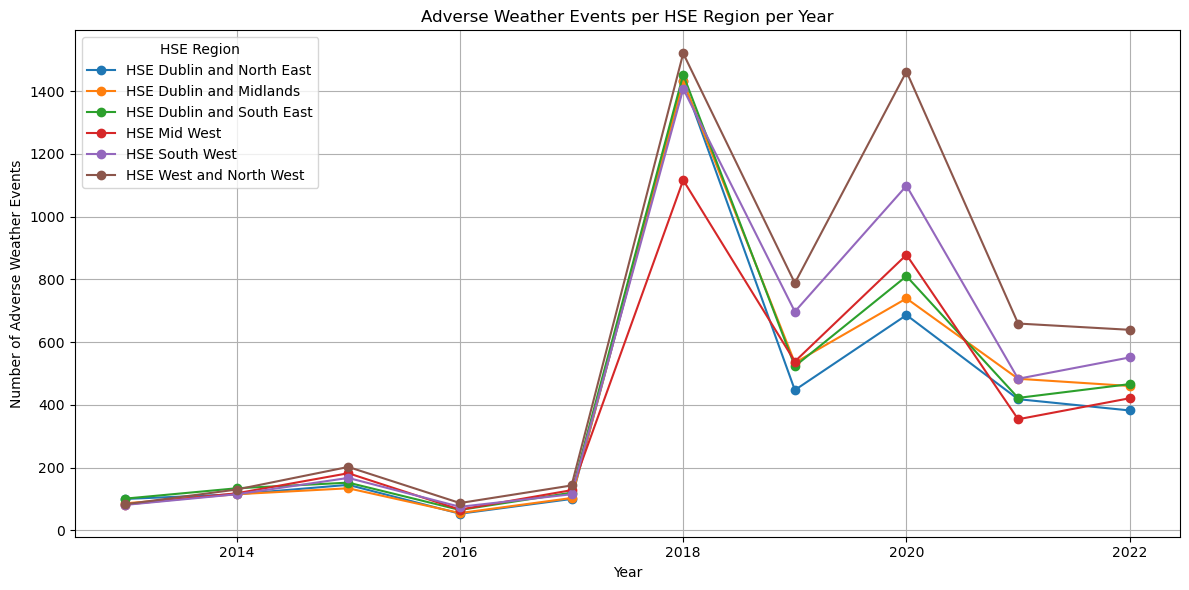

In [63]:
import matplotlib.pyplot as plt
# Plot the data
plt.figure(figsize=(12, 6))
for region in hse_region_columns:
    data = region_year_counts[region_year_counts['HSE Region'] == region]
    plt.plot(data['Year'], data['Event Count'], marker='o', label=region)

plt.xlabel('Year')
plt.ylabel('Number of Adverse Weather Events')
plt.title('Adverse Weather Events per HSE Region per Year')
plt.legend(title='HSE Region')
plt.grid(True)
plt.tight_layout()
plt.show()

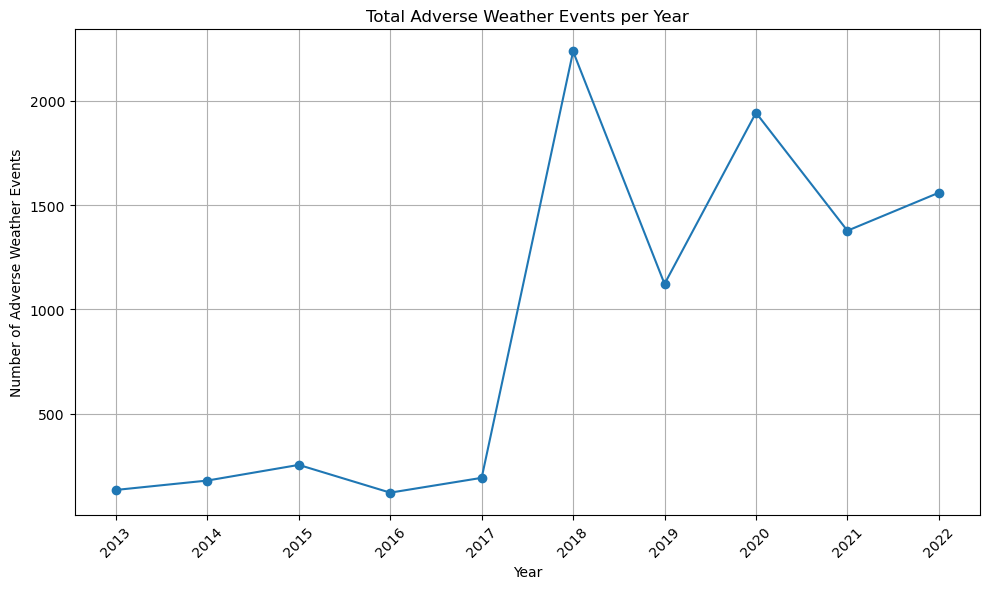

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Convert 'Issue Time' to datetime format
df_combined['Issue Time'] = pd.to_datetime(df_combined['Issue Time'], errors='coerce', utc=True)

# Step 2: Extract the year from 'Issue Time'
df_combined['Year'] = df_combined['Issue Time'].dt.year

# Step 3: Count the number of events per year
year_counts = df_combined.groupby('Year').size().reset_index(name='Event Count')

# Step 4: Plot the number of events per year
plt.figure(figsize=(10, 6))
plt.plot(year_counts['Year'], year_counts['Event Count'], marker='o')

plt.xlabel('Year')
plt.ylabel('Number of Adverse Weather Events')
plt.title('Total Adverse Weather Events per Year')
plt.grid(True)
plt.xticks(year_counts['Year'], rotation=45)
plt.tight_layout()
plt.show()


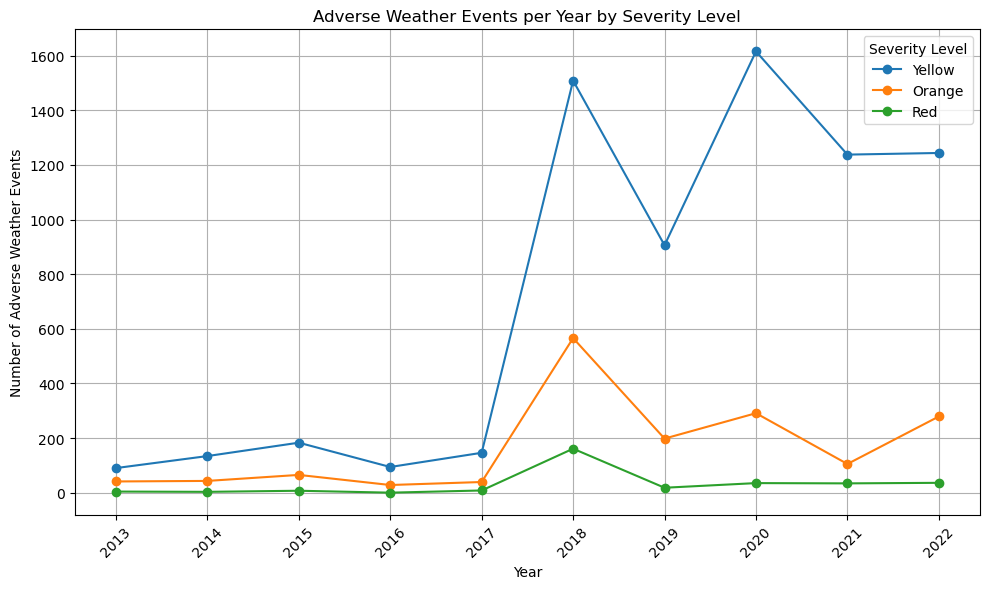

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_combined is your DataFrame

# Convert 'Issue Time' to datetime and extract 'Year'
df_combined['Issue Time'] = pd.to_datetime(df_combined['Issue Time'], errors='coerce', utc=True)
df_combined['Year'] = df_combined['Issue Time'].dt.year

# Group by 'Year' and 'Warning Colour' and count events
severity_year_counts = df_combined.groupby(['Year', 'Warning Colour']).size().reset_index(name='Event Count')

# Pivot the DataFrame for plotting
severity_pivot = severity_year_counts.pivot(index='Year', columns='Warning Colour', values='Event Count').fillna(0)

# Ensure all severity levels are included
severity_levels = ['Yellow', 'Orange', 'Red']
for level in severity_levels:
    if level not in severity_pivot.columns:
        severity_pivot[level] = 0
severity_pivot = severity_pivot[severity_levels]

# Plot the data
plt.figure(figsize=(10, 6))
for severity in severity_pivot.columns:
    plt.plot(severity_pivot.index, severity_pivot[severity], marker='o', label=severity)

plt.xlabel('Year')
plt.ylabel('Number of Adverse Weather Events')
plt.title('Adverse Weather Events per Year by Severity Level')
plt.legend(title='Severity Level')
plt.grid(True)
plt.xticks(severity_pivot.index, rotation=45)
plt.tight_layout()
plt.show()
